# Data Collection
---

In [135]:
# import necessary functions

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
import pickle

import sys, os
import shutil
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import cmocean.cm as cmo
import requests
import re
import datetime as dt
import seaborn as sns

from netCDF4 import Dataset, num2date, date2num 
from datetime import datetime, timedelta

from yodapy.datasources import OOI
ooi = OOI(cloud_source=True)

# Local application/library specific imports
#from golive_library import GoliveLibrary as g

from yodapy.utils.creds import set_credentials_file

In [136]:
sns.set()

In [2]:
set_credentials_file(data_source='ooi', username='OOIAPI-U6ZIZ5UNB1LIMA', token='TEMP-TOKEN-KDQJQSSOHX9X5Q')

In [3]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = 'OOIAPI-U6ZIZ5UNB1LIMA'
API_TOKEN = 'TEMP-TOKEN-KDQJQSSOHX9X5Q'
save_dir = ''

Set up output and data directories - but if I'm using a ton of data, do I REALLY want to be saving all of it?

eh

In [ ]:
# ooi.sites

In [ ]:
# ooi.instruments

THOUSANDS of instruments!

In [ ]:
# Narrow selection by putting desired site reference designator into search
# shallow profiler
# ooi.search('CE04OSPD')

Check the instruments now

In [ ]:
# ooi.instruments

We want the CTD instrument

In [ ]:
# Narrow selection by putting desired site reference designator into search
# 200m platform
# ooi.search('CE04OSPS')

Check the instruments now

In [ ]:
# ooi.instruments

Look at surface mooring data - looking for wind measurements

In [ ]:
# Narrow selection by putting desired site reference designator into search
# surface mooring
# ooi.search('CE04OSSM', instrument='pCO2 Air-Sea')

In [ ]:
# ooi.instruments

In [ ]:
# start_time = '2017-08-21T06:000'
# end_time = '2017-08-22T07:0000'    # the data file will include measurements close as possible to midnight on the morning of 2019-08-08 

In [ ]:
# ooi.request_data(begin_date=start_time, end_date=end_time)

In [ ]:
# # editing these
# %time req_asseet = ooi.request_data(begin_date=begin_date, end_date=end_date)
# filenamelist = ooi.to_xarray()

---
# Following along with the Endurance coastal upwelling notebook nugget

### Pull data 

Looking at just a small section of the data available:
* 200m platform at Oregon Offshore location (CE04)
* Use the CTD-O instrument, start with temperature
* March-June 2017 or 2018
* look at shallow profiler data later! 

Using this function written by lgarzio to request data from the OOI

In [37]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Use the above function to get URLs according to your API tokens. Save these URLs so you don't have to request them again every time you open this notebook.

In [131]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 
#                          'metbk_a_dcl_instrument_recovered',
#                          '2017-01-01T00:00:00.000Z', '2017-12-31T12:00:00.000Z')
# print('METBK_url: %s' %METBK_url)

METBK_url: https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030752259Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html


In [133]:
# CTD_url = request_data('CE04OSPS-SF01B-2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample',
#                         '2017-01-01T00:00:00.000Z', '2017-12-31T12:00:00.000Z')
# print('CTD_url: %s' %CTD_url)

CTD_url: https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030848056Z-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html


In [99]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 
#                          'metbk_a_dcl_instrument_recovered',
#                          '2017-03-01T00:00:00.000Z', '2017-06-30T12:00:00.000Z')
# print('METBK_url: %s' %METBK_url)

METBK_url: https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T025024382Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html


In [100]:
# CTD_url = request_data('CE04OSPS-SF01B-2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample',
#                         '2017-03-01T00:00:00.000Z', '2017-06-30T12:00:00.000Z')
# print('CTD_url: %s' %CTD_url)

CTD_url: https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T025026675Z-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html


Saved the URLs below.

In [134]:
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030752259Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030848056Z-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html'

### Load data files

This function does A LOT - will explain later

In [103]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]).replace("\\","/") for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        url_with_fillmismatch = f'{sd}#fillmismatch'
        ds = xr.open_dataset(url_with_fillmismatch, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Time to actually GET the data! Print a `.head()` of each dataset to make sure the data was successfully pulled.

In [253]:
# Specify the variable(s) of interest and get the data for the three datasets
CTD_var = ['seawater_pressure', 'seawater_temperature', 'lat', 'lon']
METBK_var = ['sea_surface_temperature', 'met_windavg_mag_corr_east', 'met_windavg_mag_corr_north']

CTD_data, CTD_units = get_data(CTD_url, CTD_var)
METBK_data, METBK_units = get_data(METBK_url, METBK_var)
print(CTD_units)
print(METBK_units)

CTD_data_copy = CTD_data
METBK_data_copy = METBK_data

Appending data from files
Appending data from files
{'seawater_pressure': ['dbar'], 'seawater_temperature': ['ºC'], 'lat': ['degrees_north'], 'lon': ['degrees_east']}
{'sea_surface_temperature': ['ºC'], 'met_windavg_mag_corr_east': ['m s-1'], 'met_windavg_mag_corr_north': ['m s-1']}


In [299]:
CTD_data = CTD_data_copy
METBK_data = METBK_data_copy

In [300]:
print(CTD_data.shape)
print(METBK_data.shape)

(21517483, 5)
(485137, 4)


In [301]:
CTD_data.head()

,time,seawater_pressure,seawater_temperature,lat,lon
14955101,2017-01-01 00:00:00.317937152,200.479041,7.785772,44.37415,-124.95648
14955102,2017-01-01 00:00:01.318152192,200.473701,7.786201,44.37415,-124.95648
14955103,2017-01-01 00:00:02.318157312,200.467264,7.786262,44.37415,-124.95648
14955104,2017-01-01 00:00:03.317954560,200.465142,7.785895,44.37415,-124.95648
14955105,2017-01-01 00:00:04.318168576,200.466196,7.785711,44.37415,-124.95648


In [302]:
METBK_data.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
325934,2017-01-01 00:00:30.432000000,11.273,4.095093,-7.196688
325935,2017-01-01 00:01:37.298999808,11.268,6.134961,-5.290137
325936,2017-01-01 00:02:41.522000384,11.267,4.501072,-4.933199
325937,2017-01-01 00:03:46.300000256,11.267,3.296377,-4.787901
325938,2017-01-01 00:04:50.525000192,11.278,4.516634,-4.688541


Yay! If one of the above printouts is empty try rerunning the cell where you got the data.

There's a bunch of plotting for the glider data that I'm skipping because I'm more interested in the platform data for this project. Will need to edit the code above so I'm not pulling data that I don't end up using.

Not sure I need to remove zeros but it's here just in case.

In [303]:
# this function can only be used if the expected values are always >0
def remove_zeros(df, variables):
    cnames = []
    for v in variables:
        if v not in ['lat', 'lon']:
            cname = v + '_ind'
            cnames.append(cname)
            df[cname] = df[v] > 0.00
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

In [304]:
# CTD_data = remove_zeros(CTD_data, CTD_var)
# METBK_data = remove_zeros(METBK_data, METBK_var)

### Quick EDA
Just check for nulls and do a `.describe()` for now.

In [426]:
METBK_data.shape

(460984, 4)

In [421]:
METBK_data.describe()

,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
count,460984.000000,460283.000000,460283.000000
mean,12.538666,1.048802,-0.618893
std,1.857096,3.037160,5.538783
min,9.854000,-11.940740,-14.488627
25%,10.601000,-0.724462,-5.049257
50%,12.393000,0.865695,-1.555359
75%,14.234000,2.725069,3.385127
max,17.580999,15.023102,21.243462


In [423]:
METBK_data.isna().sum()

time                            0
sea_surface_temperature         0
met_windavg_mag_corr_east     701
met_windavg_mag_corr_north    701
dtype: int64

In [424]:
CTD_data.describe()

,seawater_pressure,seawater_temperature,lat,lon
count,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07
mean,1.892278e+02,7.923279e+00,4.437415e+01,-1.249565e+02
std,3.956323e+01,7.240315e-01,2.273737e-12,5.087486e-12
min,1.355533e+01,6.647794e+00,4.437415e+01,-1.249565e+02
25%,2.026819e+02,7.368913e+00,4.437415e+01,-1.249565e+02
50%,2.037541e+02,7.839711e+00,4.437415e+01,-1.249565e+02
75%,2.044697e+02,8.267647e+00,4.437415e+01,-1.249565e+02
max,2.906436e+02,1.545517e+01,4.437415e+01,-1.249565e+02


In [427]:
CTD_data.shape

(21517483, 5)

In [425]:
CTD_data.isna().sum()

time                    0
seawater_pressure       0
seawater_temperature    0
lat                     0
lon                     0
dtype: int64

WOW, no nulls? Really? Wonder what cleaning was done before I got this data cause that's unbelievable. 

In [305]:
CTD_data.head()

,time,seawater_pressure,seawater_temperature,lat,lon
14955101,2017-01-01 00:00:00.317937152,200.479041,7.785772,44.37415,-124.95648
14955102,2017-01-01 00:00:01.318152192,200.473701,7.786201,44.37415,-124.95648
14955103,2017-01-01 00:00:02.318157312,200.467264,7.786262,44.37415,-124.95648
14955104,2017-01-01 00:00:03.317954560,200.465142,7.785895,44.37415,-124.95648
14955105,2017-01-01 00:00:04.318168576,200.466196,7.785711,44.37415,-124.95648


In [306]:
METBK_data.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
325934,2017-01-01 00:00:30.432000000,11.273,4.095093,-7.196688
325935,2017-01-01 00:01:37.298999808,11.268,6.134961,-5.290137
325936,2017-01-01 00:02:41.522000384,11.267,4.501072,-4.933199
325937,2017-01-01 00:03:46.300000256,11.267,3.296377,-4.787901
325938,2017-01-01 00:04:50.525000192,11.278,4.516634,-4.688541


Quick conversion from annoying timestamp to proper datetime for easier slicing later! 

In [307]:
METBK_data['time']

325934   2017-01-01 00:00:30.432000000
325935   2017-01-01 00:01:37.298999808
325936   2017-01-01 00:02:41.522000384
325937   2017-01-01 00:03:46.300000256
325938   2017-01-01 00:04:50.525000192
                      ...             
73128    2017-12-01 18:28:40.451000320
73129    2017-12-01 18:29:44.697999872
73130    2017-12-01 18:30:16.942000128
73131    2017-12-01 18:31:21.691999744
73132    2017-12-01 18:32:26.453000192
Name: time, Length: 485137, dtype: datetime64[ns]

In [308]:
METBK_data['time'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

325934    2017-01-01 00:00:30
325935    2017-01-01 00:01:37
325936    2017-01-01 00:02:41
325937    2017-01-01 00:03:46
325938    2017-01-01 00:04:50
                 ...         
73128     2017-12-01 18:28:40
73129     2017-12-01 18:29:44
73130     2017-12-01 18:30:16
73131     2017-12-01 18:31:21
73132     2017-12-01 18:32:26
Name: time, Length: 485137, dtype: object

The last couple weeks of this data have some weirdness, slice them out for now!

In [310]:
mask = (METBK_data['time'][:] > '2017-01-01') & (METBK_data['time'] <= '2017-11-15')
METBK_data = METBK_data.loc[mask]

In [311]:
METBK_data['time']

325934   2017-01-01 00:00:30.432000000
325935   2017-01-01 00:01:37.298999808
325936   2017-01-01 00:02:41.522000384
325937   2017-01-01 00:03:46.300000256
325938   2017-01-01 00:04:50.525000192
                      ...             
48975    2017-11-14 23:55:44.732999680
48976    2017-11-14 23:56:48.960999936
48977    2017-11-14 23:57:53.864999936
48978    2017-11-14 23:58:58.362999808
48979    2017-11-14 23:59:32.812000256
Name: time, Length: 460984, dtype: datetime64[ns]

In [330]:
# import numpy.ma as ma
# mask = ma.masked_less(METBK_data['met_windavg_mag_corr_north'], 0)

In [364]:
CTD_data.head()

,time,seawater_pressure,seawater_temperature,lat,lon
14955101,2017-01-01 00:00:00.317937152,200.479041,7.785772,44.37415,-124.95648
14955102,2017-01-01 00:00:01.318152192,200.473701,7.786201,44.37415,-124.95648
14955103,2017-01-01 00:00:02.318157312,200.467264,7.786262,44.37415,-124.95648
14955104,2017-01-01 00:00:03.317954560,200.465142,7.785895,44.37415,-124.95648
14955105,2017-01-01 00:00:04.318168576,200.466196,7.785711,44.37415,-124.95648


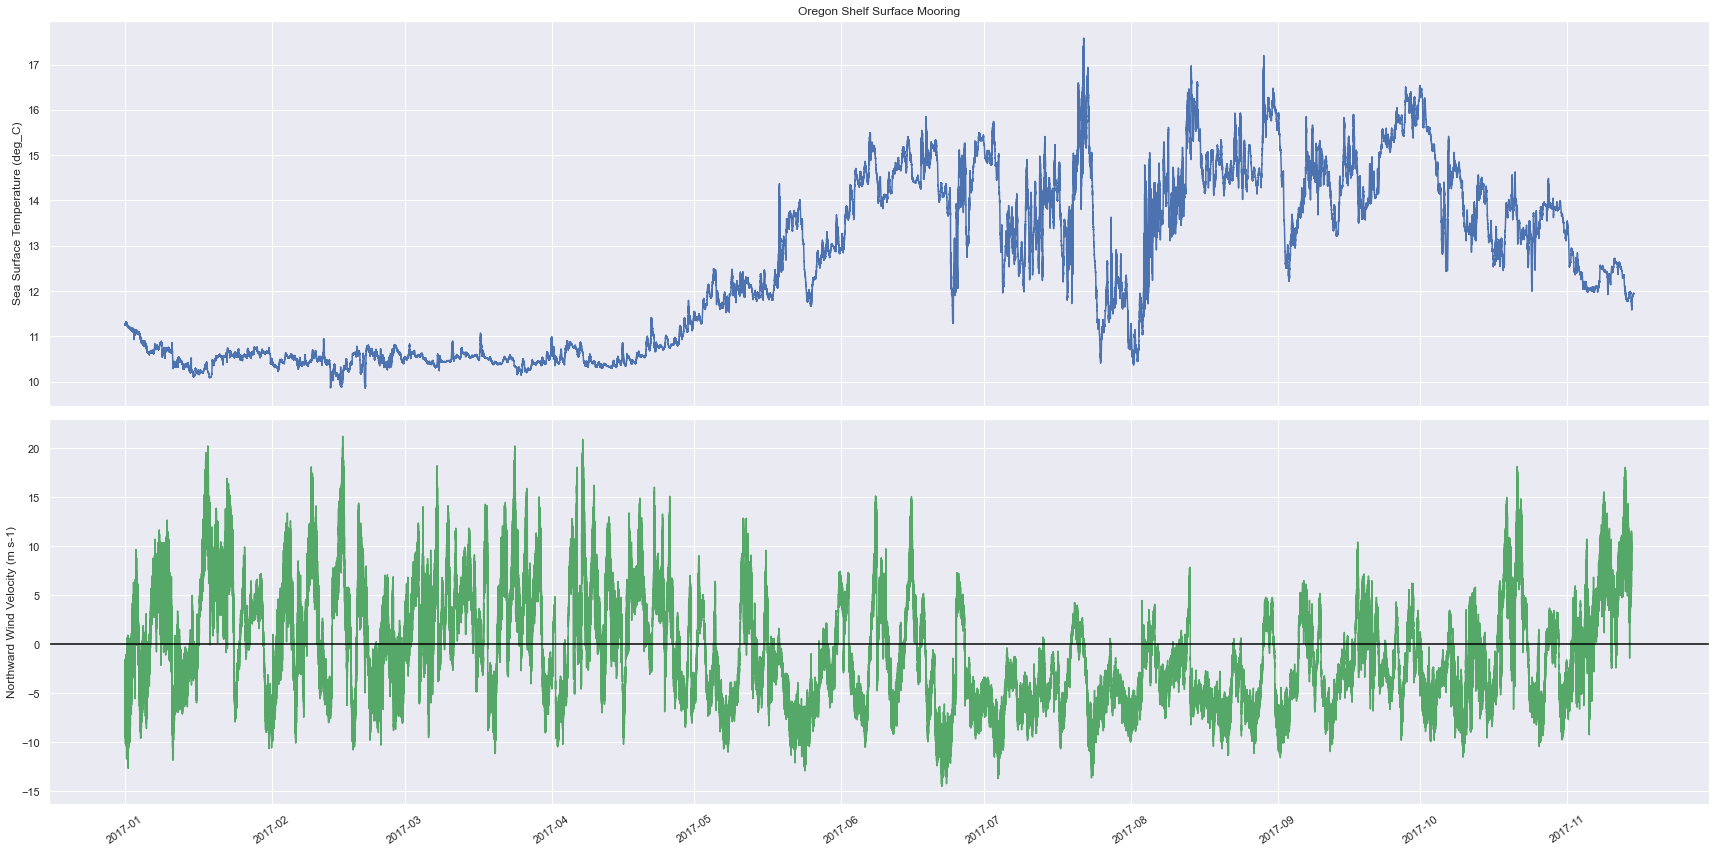

In [362]:
fig, (ax1, ax3) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) # removed ax2
ax1.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b')
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)')
ax1.set_title('Oregon Offshore METBK data')

# ax2.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_east'], 'c')
# ax2.set_xlabel('')
# ax2.set_ylabel('Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]))

ax3.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax3.set_xlabel('')
ax3.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))
ax3.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('METBK_SST_NWind.png')

Plot wind data! 

---
# METBK data

In [336]:
# calculate the percentage of time during this time range that winds are blowing towards the south
north_winds = np.array(METBK_hourly['met_windavg_mag_corr_north'])
upwelling_percentage = len(north_winds[north_winds < 0]) / len(north_winds) * 100
print('{}%'.format(round(upwelling_percentage)))

58%


In [334]:
METBK_hourly = METBK_data.resample('H', on='time').mean().dropna(how='all').reset_index()
#METBK_hourly.head()
METBK_daily = METBK_data.resample('D', on='time').mean().dropna(how='all').reset_index()
METBK_daily.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2017-01-01,11.247412,6.413056,-5.371468
1,2017-01-02,11.149430,-1.148830,-1.207261
2,2017-01-03,11.089363,-5.203772,2.533484
3,2017-01-04,10.926763,-6.222477,-4.027738
4,2017-01-05,10.756387,-6.911579,-3.048631


In [436]:
# rename the columns and add units
METBK_hourly = METBK_hourly.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})
METBK_daily = METBK_daily.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})
# Grab times of interest
mask = (METBK_hourly['time'][:] > '2017-05-01') & (METBK_hourly['time'] <= '2017-08-01')
METBK_summer_data = METBK_hourly.loc[mask]

METBK_summer_data.head()

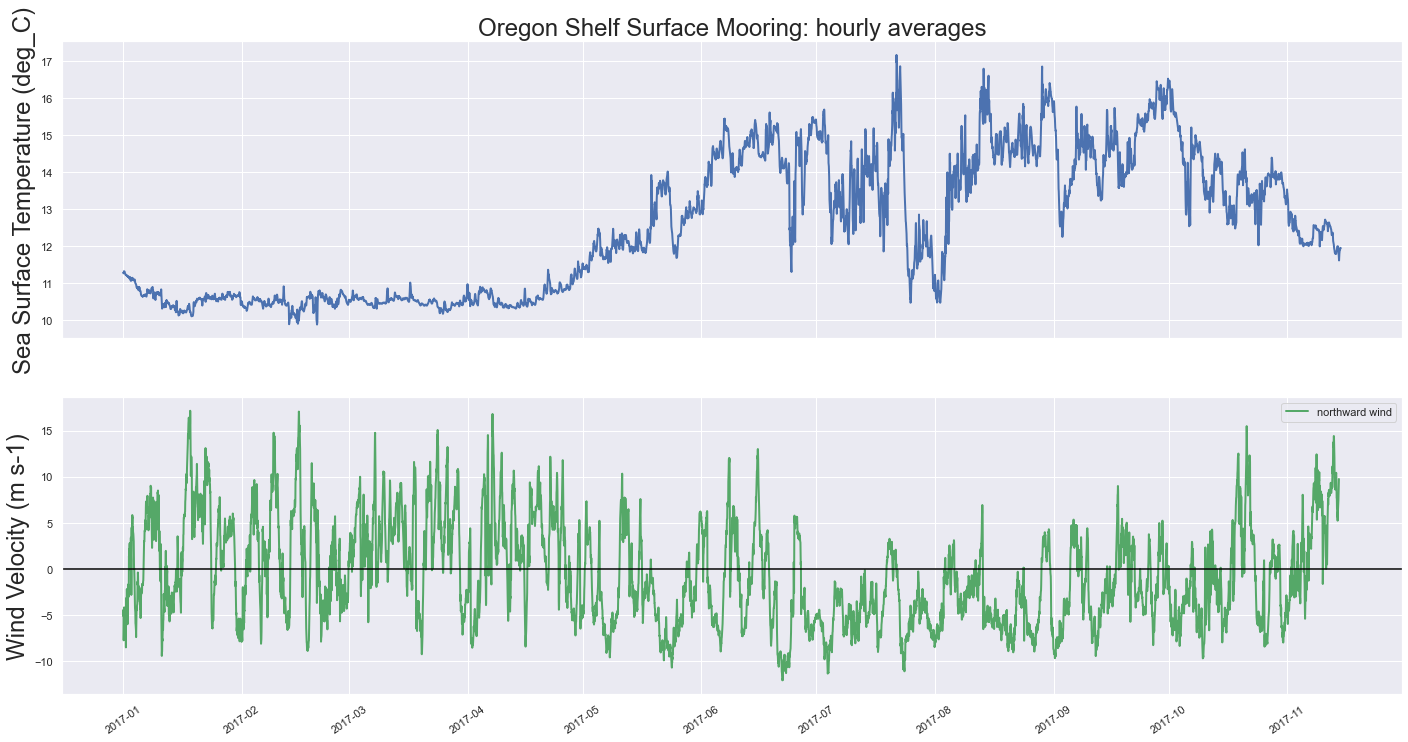

In [354]:
# Plot hourly-averaged METBK data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)', size=24)
ax1.set_title('Oregon Offshore METBK hourly averages', size=24)

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind', linewidth=2)
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

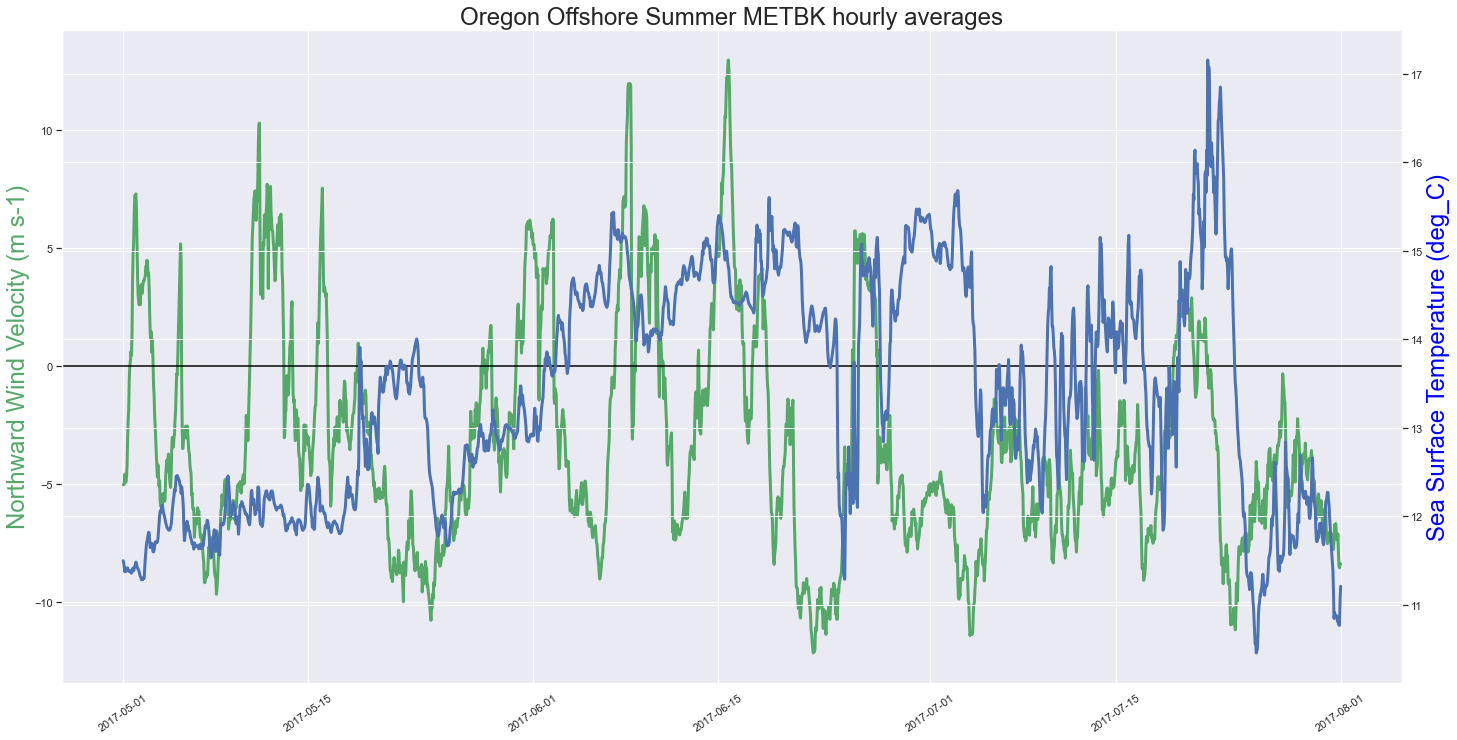

In [438]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(METBK_summer_data['time'], METBK_summer_data['Northward Wind Velocity (m s-1)'], 'g', linewidth=3)
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax2 = ax.twinx()  # instantiate a second axis that shares the same x-axis
ax2.plot(METBK_summer_data['time'], METBK_summer_data['Sea Surface Temperature (deg_C)'], 'b', linewidth=3)
ax2.set_ylabel('Sea Surface Temperature (deg_C)', color='blue', size=24)

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

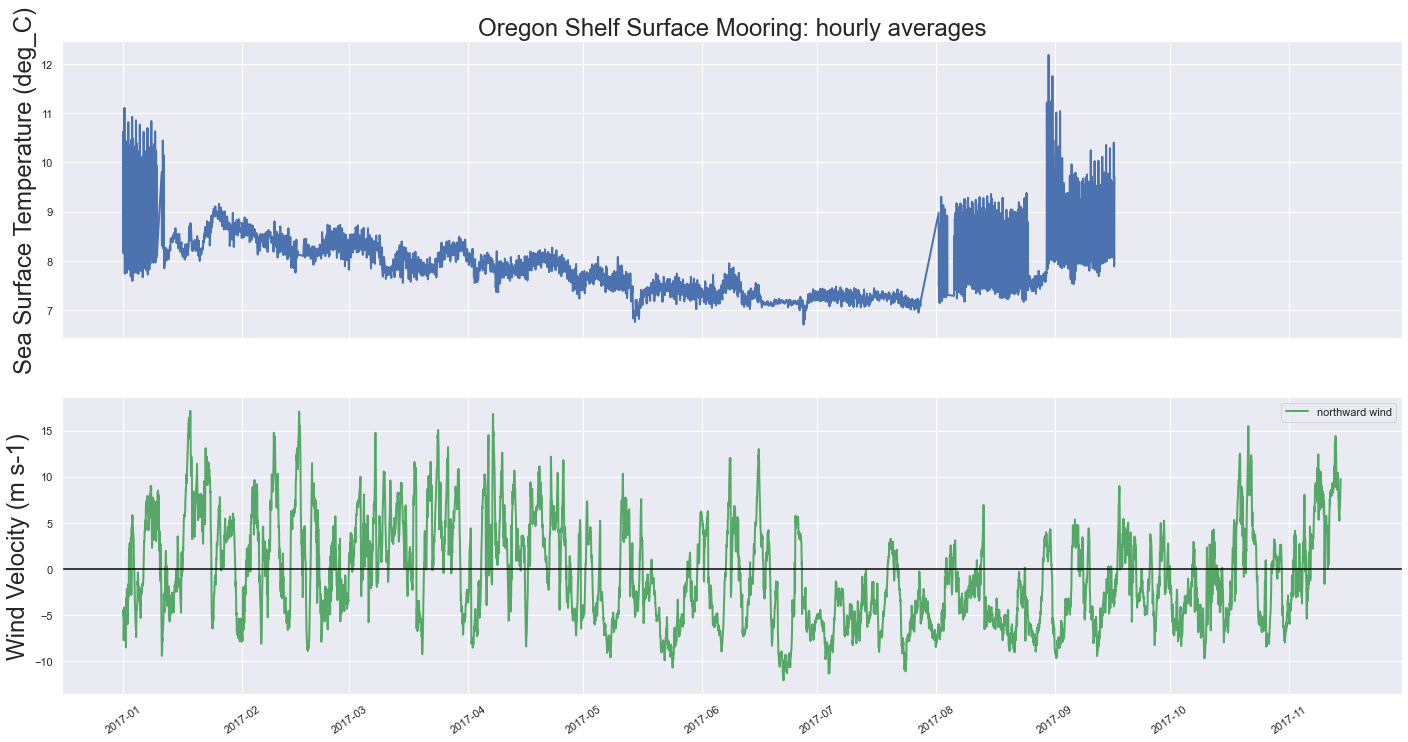

In [383]:
# Plot hourly-averaged METBK data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(CTD_hourly['time'], CTD_hourly['seawater_temperature'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)', size=24)
ax1.set_title('Oregon Offshore CTD hourly averages', size=24)

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind', linewidth=2)
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

---
# CTD data
Time to look at the CTD data collected by the shallow profiler! These go up an down in the water column (top 200m) 9 times a day. Good example plots of profiler paths and change in temp and salinity with depth in the notebook of [yodapy example plots](https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb).


In [408]:
CTD_data.shape

(21517483, 5)

In [442]:
CTD_minutes = CTD_data.resample('T', on='time').mean().dropna(how='all').reset_index()
METBK_minutes = METBK_data.resample('T', on='time').mean().dropna(how='all').reset_index()
#CTD_minutes.head()

CTD_hourly = CTD_data.resample('H', on='time').mean().dropna(how='all').reset_index()
#METBK_hourly.head()
CTD_daily = CTD_data.resample('D', on='time').mean().dropna(how='all').reset_index()
#CTD_daily.head()

In [410]:
# Grab times of interest
mask = (CTD_data['time'][:] > '2017-05-01') & (CTD_data['time'] <= '2017-06-30')
CTD_summer = CTD_data.loc[mask]

CTD_summer

In [445]:
METBK_summer

101376   2017-03-01 00:00:39.286999552
101377   2017-03-01 00:01:45.703000064
101378   2017-03-01 00:02:50.621999616
101379   2017-03-01 00:03:25.652999680
101380   2017-03-01 00:04:29.888999936
                      ...             
101371   2017-06-30 11:56:02.734000128
101372   2017-06-30 11:57:06.515999744
101373   2017-06-30 11:58:10.904999936
101374   2017-06-30 11:58:45.291999744
101375   2017-06-30 11:59:49.539999744
Name: time, Length: 175721, dtype: datetime64[ns]

In [404]:
mask = (CTD_minutes['time'][:] > '2017-05-01') & (CTD_minutes['time'] <= '2017-06-30')
CTD_summer_minutes = CTD_minutes.loc[mask]

CTD_summer_minutes.shape

In [443]:
mask = (METBK_minutes['time'][:] > '2017-05-01') & (METBK_minutes['time'] <= '2017-06-30')
METBK_summer_minutes = METBK_minutes.loc[mask]

METBK_summer_minutes.shape

(81224, 4)

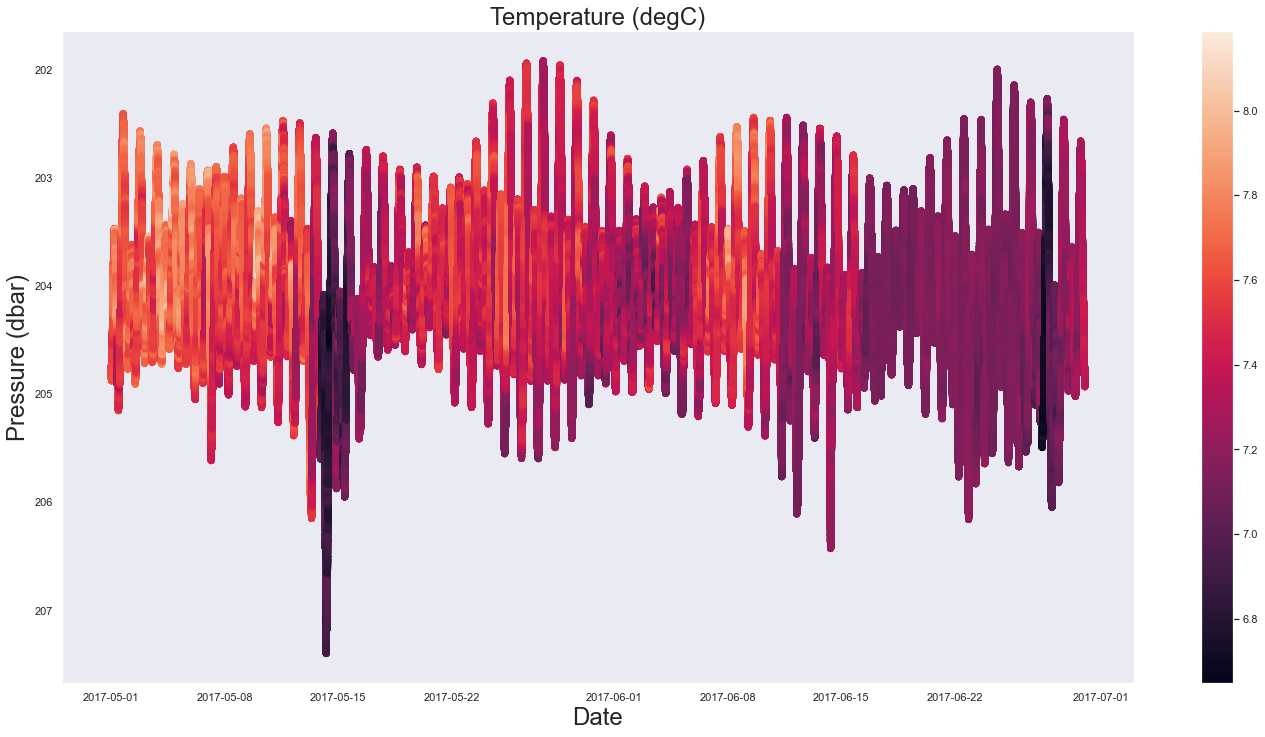

In [455]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_summer['time'],CTD_summer['seawater_pressure'],c=CTD_summer['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('CTD_profiler_temperature.png')

In [453]:
#METBK_summer_minutes

In [450]:
METBK_summer_minutes = METBK_summer_minutes.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})

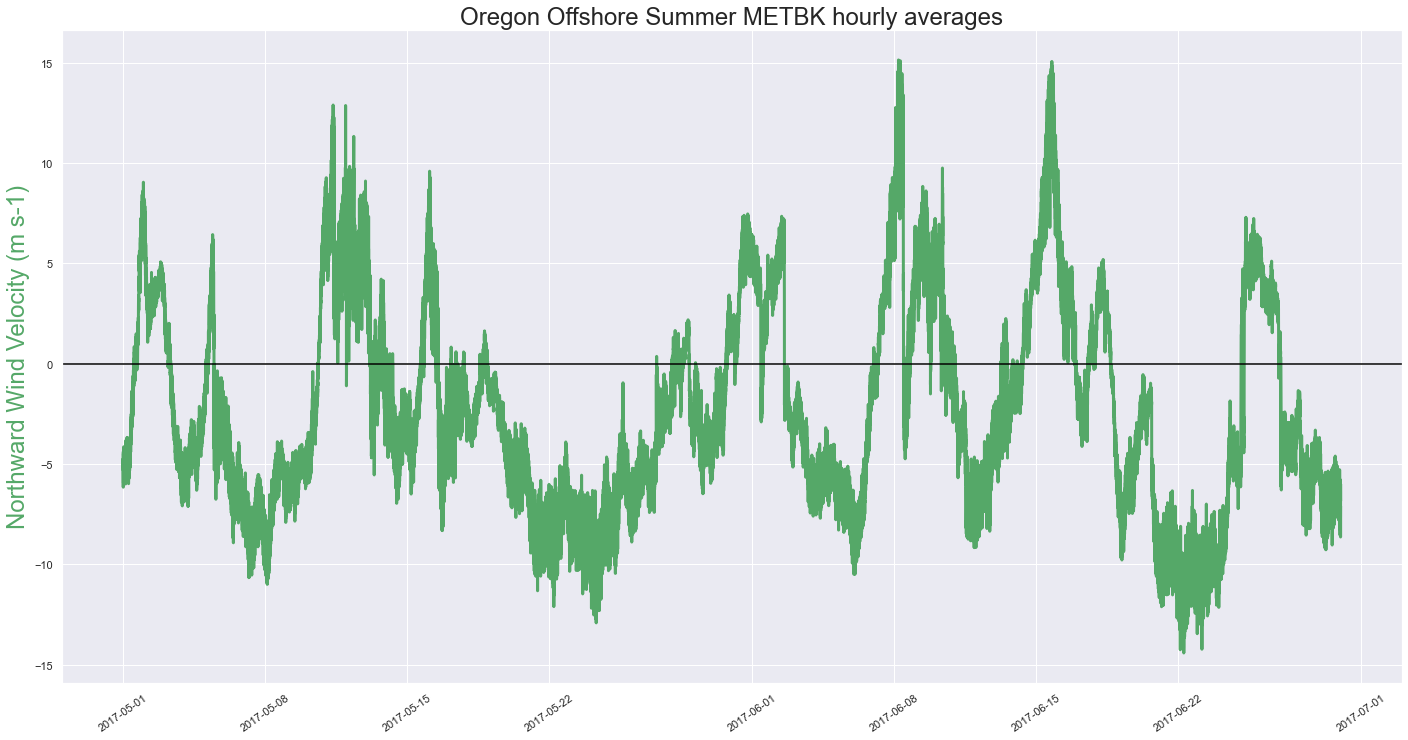

In [452]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(METBK_summer_minutes['time'], METBK_summer_minutes['Northward Wind Velocity (m s-1)'], 'g', linewidth=3)
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

This is weird, let's look at 1 week of data instead of 2 months.

In [440]:
mask = (CTD_data['time'][:] > '2017-08-20') & (CTD_data['time'] <= '2017-08-25')
CTD_week = CTD_data.loc[mask]

CTD_week.shape

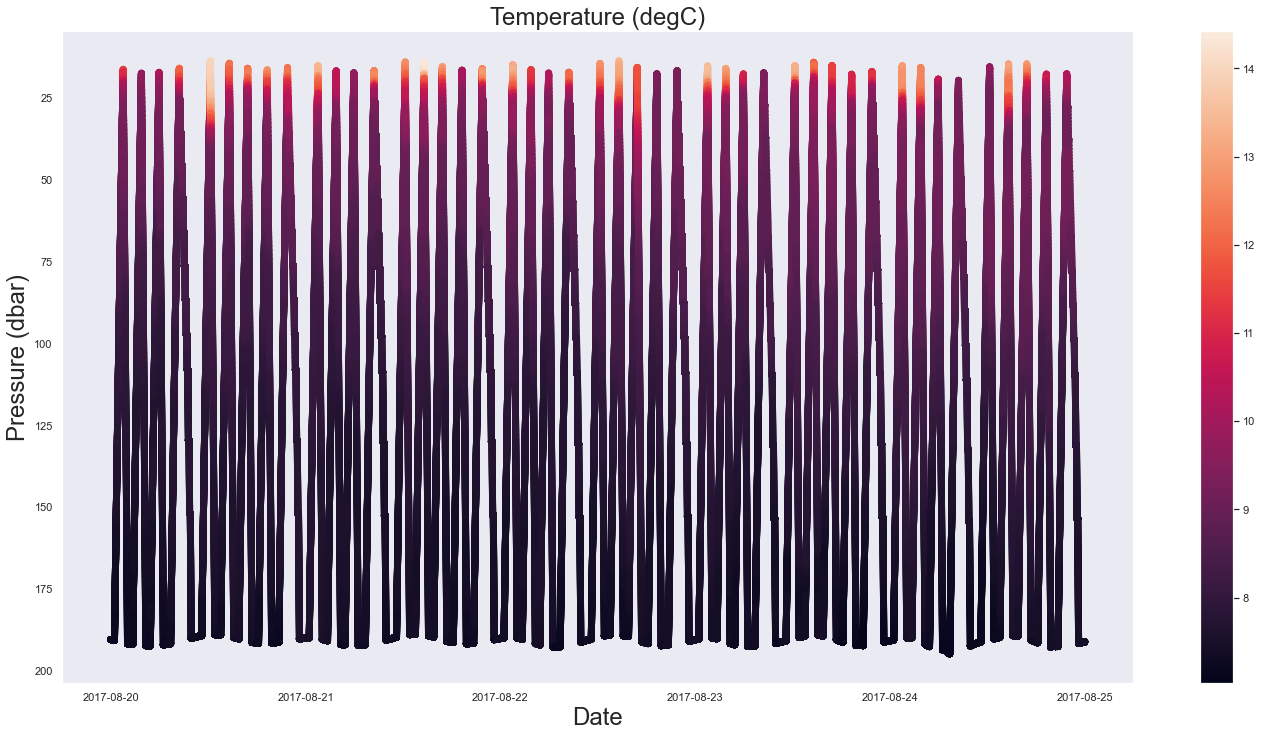

In [441]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('CTD_profiler_week.png')

Notice how wavy the bottom of this pattern is? Those are probably the daily tide cycle!!

Need to add practical salinity to variables that I pull in in order to plot the above with salinity data - this would be nice because seawater temperature and salinity are inversely related, so we expect to see the same pattern in both variables - is this what you see? 

### Be careful saving this data! 
It can save a lot of time BUT it's very easy to accidentally overwrite something that you really needed! 

In [361]:
# METBK_data_copy.to_csv('METBK_01-01_12-01.csv', index=False)
# CTD_data_copy.to_csv('CTD_01-01_12-01.csv', index=False)

In [146]:
# METBK_hourly.to_csv('METBK_03-01_06_30.csv', index=False)
# CTD_data.to_csv('CTD_03-01_06_30.csv', index=False)